# Importing and visualizing the original Dataset - MSR Action 3D

## About the dataset
The dataset shows 567 depth map sequences of people doing actions. There are 20 different actions (our labels):


*   a01 High arm wave
*   a02 Horizontal arm wave
*   a03 Hammer
*   a04 Hand catch
*   a05 Forward punch
*   a06 High throw
*   a07 Draw cross
*   a08 Draw tick
*   a09 Draw circle
*   a10 Hand clap  
*   a11 Two-hand wave 
*   a12 Side-boxing 
*   a13 Bend 
*   a14 Forward kick
*   a15 Side-kick
*   a16 Jogging
*   a17 Tennis swing 
*   a18 Tennis serve
*   a19 Golf swing 
*   a20 Pick-up and throw


20 actions (a01 - a20, see above)
10 subjects performing the actions (s01 - s10)
Each subject performs action 2-3 times (e01-e03)

### The following lines "unrar" the depth map and the skeleton real 3D data. 

In [ ]:
!unrar x "/content/drive/MyDrive/Depth.rar" "/content/drive/MyDrive/folder/Depth_unrar/"

In [ ]:
!unrar x "/content/drive/MyDrive/MSRAction3DSkeletonReal3D" "/content/drive/MyDrive/folder/SkeletonReal_unrar/"

In [ ]:
!unrar x "/content/drive/MyDrive/MSRAction3DSkeleton(20joints)" "/content/drive/MyDrive/folder/Skeleton20Joints_unrar/"

### The following code block imports all the libraries and functions we need - please don't forget to re-execute when restarting the runtime

In [1]:
# Needed imports

import sys
import os
from os.path import join
from os import listdir
import time

import numpy as np
import pandas as pd


import struct
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from matplotlib.pyplot import imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Working with Depth Maps


In [4]:
path, dirs, files = next(os.walk("/content/drive/MyDrive/folder/Depth_unrar/Depth"))
file_count = len(files)
print(file_count)
# This is the number of depth map sequences ... binary files

567


In [5]:
"""
  This function will take the binary file, read the number of frames and dimensions
  from the first 12 bytes and then read the rest of the file in frames:
    * Read the bytes in a list of ints
    * Parse to float values
    * Split the list in a list of list with regard to the frame size
    * For each frame, resize the data using the dimensions read from the binary file
"""

def load_depth_map(path):
  with open(path,'rb') as fin:
    numframes = struct.unpack('i', fin.read(4))[0]
    dims = struct.unpack('i', fin.read(4))[0],struct.unpack('i', fin.read(4))[0]
    data_array = np.fromfile(fin, np.int32)
    depth = data_array.astype(float) #convert to double for imaging  
    frames = np.split(depth, numframes)
    depthMap = []
    for frame in frames:
      depthMap.append(np.reshape(frame, dims))

    print(f'Number of frames: {numframes}')
    print(f'Dimension of each frame: {dims}')

    return depthMap

In [6]:
"""
  This methods prints the matrix as a depth map
"""
def show_depth_map(depth_map):
  plt.figure()
  plt.imshow(depth_map)
  plt.colorbar()
  plt.show()

In [7]:
"""
  This method goes through all frames and shows the depth map
  one after the other
"""

def show_depth_sequence(depth_seq):
  for i in depth_seq:
    show_depth_map(i)
    time.sleep(0.001)

In [8]:
load_depth_map

<function __main__.load_depth_map>

In [ ]:
# Call the above methods 

depthMapArray = load_depth_map('/content/drive/MyDrive/folder/Depth_unrar/Depth/a20_s10_e01_sdepth.bin')
#print(depthMapArray)
show_depth_sequence(depthMapArray)

# Importing and visualizing the skeleton Dataset - MSR Action Skeleton Real 3D



Four real numbers are stored for each joint (20 joints): u, v, d, c 
(u,v): screen coordinates
d: the depth value 
c: confidence score

If a depth sequence has n frames, then the number of real numbers stored in the corresponding skeleton file is equal to: n*20 (number joints) * 4 (number coordinates + confidence)

Source for some of the implementation ideas: [here](https://github.com/yavuzKomecoglu/MSR-Action-Recognition/blob/master/MSRAction3D_Dataset_Reading_Visualization.ipynb) and within the Matlab code examples published [here](https://sites.google.com/view/wanqingli/data-sets/msr-action3d?authuser=0).

In [10]:
def read(path):
  print("Reading in skeleton data...")

  # Get a list of all files the right order
  file_names = sorted(listdir(path))
  files = [join(path, file) for file in file_names]

  data, labels, frame_sizes, subjects = [], [], [], []
  
  print(len(files))
  for file in files:
    # Get only first three values (for coordinates) and not the confidence score
    action = np.loadtxt(file)[:, :3].flatten()


    # Get the label, the subject and the number of performance from filename
    parts = file.split("/").pop().split("_")[:3]
    label, subject, e = [int(x[1:].lstrip('0')) for x in parts]

  
    # Get the frame size: divide actions by 60 (20 (number joints) * 3 (number coordinates))
    frame_size = len(action) // 60
    

    # Append label (action), subject, frame_size
    labels.append(label)
    subjects.append(subject)
    frame_sizes.append(frame_size)
  

    # Get one entry for each frame, containing the 20 joints with 3 coordinates
    action = np.split(action, frame_size)

    data.append(action)

  data = np.asarray(data)
  labels = np.asarray(labels)
  frame_sizes = np.asarray(frame_sizes)
  subjects = np.asarray(subjects)

  print(f'Shapes - data: {data.shape}, labels: {labels.shape}, subjects: {subjects.shape}, frame_size: {frame_sizes.shape}')
  return data,labels, subjects, frame_sizes

In [13]:
data,labels, subjects, frame_sizes = read('/content/drive/MyDrive/folder/Skeleton20Joints_unrar/')

Reading in skeleton data...
567
Shapes - data: (567,), labels: (567,), subjects: (567,), frame_size: (567,)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
# To get all examples for a specific movement, we just have to get the area within our data array

def get_activities(data, labels, activity):
  # Get all indices for the activity from our labels
  indices = [i for i, label in enumerate(labels) if label == activity]

  # Set first index as start, last as end
  action_start = indices[0]
  action_end = indices[-1]
  
  # Get all our examples from the data
  action_examples = data[action_start : action_end + 1]
  return action_examples


action_examples =get_activities(data, labels, 16)

for example in action_examples:
  example = np.asarray(example)
  #print(example.shape)

## ANIMATION FROM SOURCE

In [15]:
from weakref import ref

def loadData(action, subject, instance):
    instance = np.loadtxt(f'/content/drive/MyDrive/folder/Skeleton20Joints_unrar/a{action}_s{subject}_e{instance}_skeleton.txt')
    print("instance.shape: ",instance.shape)
    print("instance.shape[0]: ",instance.shape[0])
    instance = instance.reshape((instance.shape[0]//20, 20, 4))
    return instance


def animate(i):
    for line in ax.lines:
      ax.lines.pop(0)
    graph_edges = [[20, 1, 2, 1, 8 , 10, 2, 9 , 11, 3, 4, 7, 7, 5 , 6 , 14, 15, 16, 17],
                    [3 , 3, 3, 8, 10, 12, 9, 11, 13, 4, 7, 5, 6, 14, 15, 16, 17, 18, 19]]
    graph._offsets3d = (data[i,:,0], data[i,:,2], data[i,:,1])
    for o in range(19):
      edge1 = graph_edges[0][o] - 1 # it goes from 0 to 19 not from 1 to 20, that's why there is a minus 1
      edge2 = graph_edges[1][o] - 1
      p1x, p1y, p1z, cs1 = data[i,edge1,:]
      p2x, p2y, p2z, cs2 = data[i,edge2,:]
      x = np.array([p1x, p2x])
      y = np.array([p1y, p2y])
      z = np.array([p1z, p2z])
      ax.plot(x, z, y, color='pink')
    return graph

In [16]:
data = loadData('07', '01', '01')
print(data.shape)

instance.shape:  (860, 4)
instance.shape[0]:  860
(43, 20, 4)


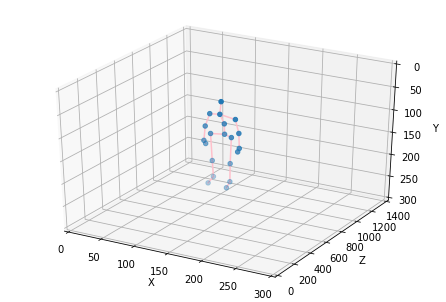

In [22]:
fig = plt.figure()

ax = p3.Axes3D(fig)

# Setting the axes properties
# x_max = np.max(data[:,:,0])
# x_min = np.min(data[:,:,0])

ax.set_xlim3d([0.0, 300.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1400.0])
ax.set_ylabel('Z')

ax.set_zlim3d([300.0, 0.0])
ax.set_zlabel('Y')

graph = ax.scatter([], [], [])

anim = FuncAnimation(fig, animate, frames=data.shape[0], interval=100)
plt.show
anim


In [24]:
from matplotlib import rc
rc('animation', html='jshtml')
anim